**多层感知机**

@ Follow: "动手学深度学习-第四章 多层感知机"

In [30]:
import numpy as np
from d2l import torch as d2l
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import nn
import torchvision
from torchvision import transforms
from IPython import display


dir_data = Path("/Users/rui/Code/Astronote/32_PyTorch/data/chapter4")
dir_data.mkdir(parents=True, exist_ok=True)

In [15]:
def load_data_fashion_mnist(batch_size, resize=None, download=False):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=dir_data, train=True, 
                                                    transform=trans, download=download)
    mnist_test = torchvision.datasets.FashionMNIST(root=dir_data, train=False, 
                                                   transform=trans, download=download)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, 
                                        num_workers=4),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, 
                                        num_workers=4))

In [16]:
class Accumulator:
    """在`n`个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期(定义见第3章)"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 3)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型(定义见第3章)"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 1, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


In [17]:
def predict_ch3(net, test_iter, n=6):
    """预测标签(定义见第3章)"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

# 基本概念
- 多层感知机(Multilayer Perceptron, MLP)是最简单的深度神经网络
- MLP的架构：将许多全连接层堆叠在一起，每一层都输出到其上面的层，直到生成最后的输出
- 在网络中加入一个或多个隐藏层来突破线性模型的限制，使其能够处理更普遍的函数关系
- 直接添加隐藏层相当于对仿射函数做仿射变换，结果还是仿射函数，还是线性模型。因此对仿射变换之后的每个隐藏单元应用非线性的激活函数，使MLP不再退化成线性模型。
- 更深，而不是更广的网络，可以更容易地逼近许多函数

# 常见的激活函数

## 修正线性单元(Recified Linear Unit, ReLU)
- 函数: $\rm ReLU(x) = max(x, 0)$, 即元素和0中的最大值，保留正元素，丢弃所有负元素
- 使用ReLU的原因是它的求导表现特别好: 要么参数消失, 要么参数通过
- 一个ReLU的变体, 参数化ReLU (parameterized ReLU, pReLU): $\rm pReLU(x) = max(0, x) + \alpha min(0, x)$

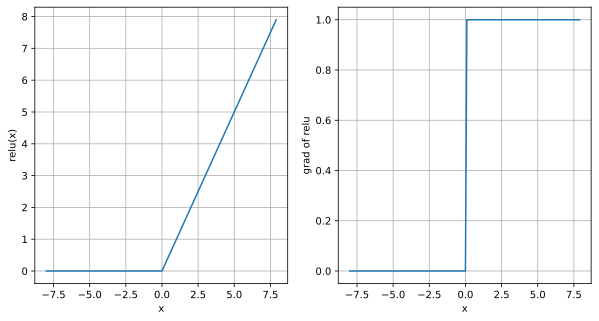

In [18]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
y.backward(torch.ones_like(x), retain_graph=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(x.detach().numpy(), y.detach().numpy())
axes[0].set_xlabel('x')
axes[0].set_ylabel('relu(x)')
axes[0].grid()

axes[1].plot(x.detach().numpy(), x.grad.numpy())
axes[1].set_xlabel('x')
axes[1].set_ylabel('grad of relu')
axes[1].grid()

## Sigmoid函数
- Sigmoid函数也称挤压函数: 它将任意数值压缩到(0, 1)上的某个值
- 函数: $\rm sigmoid(x) = \frac{1}{1 + exp(-x)}$
- Sigmoid函数在隐藏层中较少使用, 大部分时候被更简单的ReLU所取代
- Sigmoid函数的导数: $\rm \frac{d}{dx} sigmoid(x) = sigmoid(x)(1 - sigmoid(x))$

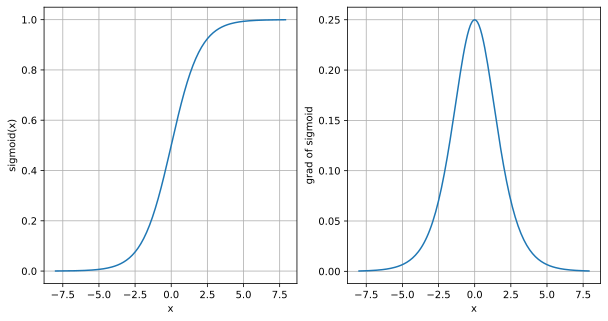

In [19]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x), retain_graph=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(x.detach().numpy(), y.detach().numpy())
axes[0].set_xlabel('x')
axes[0].set_ylabel('sigmoid(x)')
axes[0].grid()

axes[1].plot(x.detach().numpy(), x.grad.numpy())
axes[1].set_xlabel('x')
axes[1].set_ylabel('grad of sigmoid')
axes[1].grid()

## 双曲正切函数(tanh)
- 类似sigmoid函数, 能将任意数值压缩到(-1, 1)区间
- 函数: $\rm tanh(x) = \frac{1-exp(-2x)}{1+exp(-2x)}$
- 导数: $\rm \frac{d}{dx} tanh(x) = 1 - tanh^2(x)$

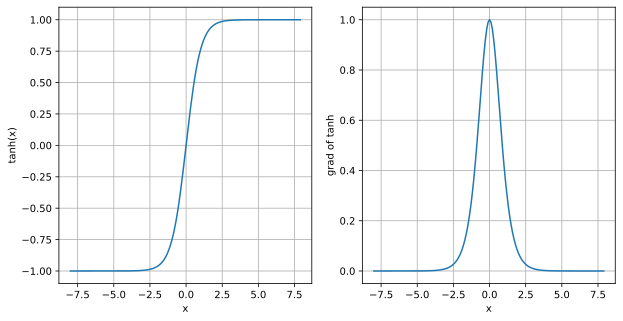

In [20]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.tanh(x)
y.backward(torch.ones_like(x), retain_graph=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(x.detach().numpy(), y.detach().numpy())
axes[0].set_xlabel('x')
axes[0].set_ylabel('tanh(x)')
axes[0].grid()

axes[1].plot(x.detach().numpy(), x.grad.numpy())
axes[1].set_xlabel('x')
axes[1].set_ylabel('grad of tanh')
axes[1].grid()

---
# 多层感知机

In [21]:
# 加载数据集
batch_size = 256

train_iter, test_iter = load_data_fashion_mnist(batch_size, download=False)

## 初始化模型
- 隐藏层宽度一般为2的N次幂, 提高硬件的计算效率

In [22]:
num_inputs = 784  # 输入层宽度为特征数量, 即28 * 28 = 784
num_outputs = 10  # 输出层宽度为类别数量
num_hiddens = 256  # 隐藏层宽度

W1 = nn.Parameter(
    torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01
)
b1 = nn.Parameter(
    torch.zeros(num_hiddens, requires_grad=True)
)
W2 = nn.Parameter(
    torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01
)
b2 = nn.Parameter(
    torch.zeros(num_outputs, requires_grad=True)
)
params = [W1, b1, W2, b2]

## 激活函数

In [23]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 定义向前传播函数

In [24]:
def net(X):
    X = X.reshape(-1, num_inputs)
    H = relu(X @ W1 + b1)
    return (H @ W2 + b2)

## 损失函数

In [25]:
loss = nn.CrossEntropyLoss(reduction='none')

## 训练

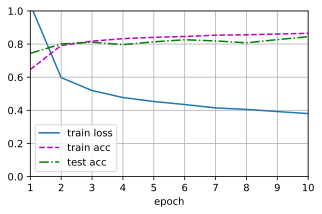

In [26]:
num_epochs, lr = 10, 0.1

updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

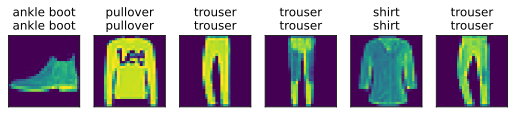

In [27]:
predict_ch3(net, test_iter)

---
# MLP的简洁实现

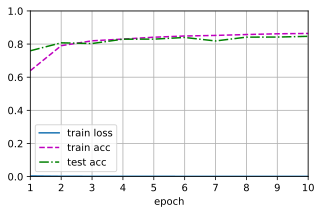

In [13]:
net_new = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_new.apply(init_weights)

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net_new.parameters(), lr=lr)

train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net_new, train_iter, test_iter, loss, num_epochs, trainer)

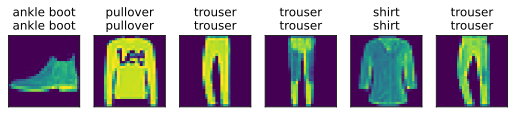

In [28]:
predict_ch3(net_new, test_iter)

---
# 过拟合与欠拟合
- 训练误差: 模型在训练数据集上计算到的误差
- 泛化误差: 模型应用在同样从原始样本的分布中抽取的`无限多数据样本(理想的测试集)`时, 模型误差的期望
- 关于模型复杂性:
    1. 具有较多参数的模型可能被认为更复杂
    2. 具有较大取值范围的模型可能更复杂
    3. 很难比较不同大类的模型(如, 决策树和神经网络)的复杂性
- 关于验证集:
    1. 为确定候选模型(不同超参数)中的最佳模型, 通常会使用验证集
    2. 在确定所有超参数之前, 不要用到测试集
    3. 没有足够多的数据划分验证集时, 可以使用K折交叉验证
- 关于过拟合:
    1. 最好的预测模型在训练数据上的表现往往比验证数据上好的多
    2. 通常更关心验证误差, 而不是训练误差和验证误差之间的差距
    3. 数据量增加, 泛化能力通常会变好

## 生成数据
- 给定x, 生成3阶多项式生成数据
    $$y = 5 + 1.2 x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon$$

In [ ]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小

true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

featrues = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(featrues)

poly_features = np.power(featrues, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= np.math.gamma(i + 1)  # `gamma(n)` = (n-1)!

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)  # labels对应y

# NumPy ndarray转换为tensor
true_w, featrues, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, featrues, poly_features, labels]
]

## 定义损失

In [45]:
def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

## 定义训练函数

In [ ]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]  # 特征数
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)

    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (
                evaluate_loss(net, train_iter, loss), 
                evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 三阶多项式函数拟合
- 模拟的真值函数就是3阶多项式, 因此3阶是最佳模型

weight: [[ 5.0068803  1.2080268 -3.390756   5.598307 ]]
True w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000])


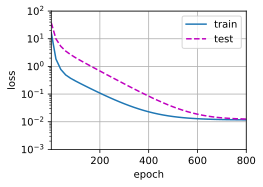

In [58]:
train(
    train_features=poly_features[:n_train, :4],
    test_features=poly_features[n_train:, :4],
    train_labels=labels[:n_train],
    test_labels=labels[n_train:],
    num_epochs=800
)
print(f"True w: {true_w[:4]}")

## 线性函数(欠拟合)

weight: [[3.52438   2.8736117]]
True w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000])


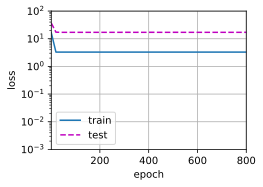

In [65]:
train(
    train_features=poly_features[:n_train, :2],
    test_features=poly_features[n_train:, :2],
    train_labels=labels[:n_train],
    test_labels=labels[n_train:],
    num_epochs=800
)
print(f"True w: {true_w[:4]}")

## 使用高阶多项式(过拟合)

weight: [[ 4.9921165   1.1992683  -3.28971     5.515381   -0.44698092  0.86289877
   0.19720007  0.25715464 -0.09143837  0.05794594 -0.15933858  0.11127388
  -0.15720648  0.03402768 -0.1093142  -0.02168672 -0.02997723 -0.06946835
   0.12908706  0.20875216]]
True w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])


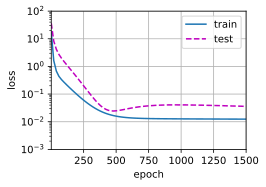

In [67]:
train(
    train_features=poly_features[:n_train, :],
    test_features=poly_features[n_train:, :],
    train_labels=labels[:n_train],
    test_labels=labels[n_train:],
    num_epochs=1500
)
print(f"True w: {true_w[:]}")

---
# 权重衰减